In [0]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-8ybbquow
All libraries are successfully installed!


In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True)

Files already downloaded and verified


In [0]:
from tqdm import tqdm_notebook
from PIL import Image
import numpy as np
n = 0
s = np.zeros(3)
sq = np.zeros(3)
for data, l in tqdm_notebook(train):
  x = np.array(data)/255
  s += x.sum(axis=(0,1))
  sq += np.sum(np.square(x), axis=(0,1))
  n += x.shape[0]*x.shape[1]

mu = s/n
std = np.sqrt((sq/n - np.square(mu)))
print(mu, sq/n, std, n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys



[0.49139968 0.48215841 0.44653091] [0.30249857 0.29176174 0.26781806] [0.24703223 0.24348513 0.26158784] 51200000


In [0]:
import sys
sys.path.append('/content/drive/My Drive/EVA4')

# Data Transformations with **Albumentations**

In [0]:
import numpy as np
from evadatatransforms import AlbumentationTransforms
import albumentations as A

channel_means = (0.49139968, 0.48215841, 0.44653091)
channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# Train Phase transformations
train_transforms = AlbumentationTransforms([
                                       A.Rotate((-30.0, 30.0)),
                                       A.PadIfNeeded(40,40),
                                       A.RandomCrop(32,32),
                                       A.HorizontalFlip(),
                                       A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=8) # fillvalue is 0 after normalizing as mean is 0
                                       ])

fillmeans = (np.array(channel_means)).astype(np.uint8)



# Test Phase transformations
test_transforms = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])



# Loading and Split Datasets into Train and Test

In [0]:
from torchvision import datasets
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
import dataloaders

dataloader = dataloaders.DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

torch.Size([128, 3, 32, 32])
torch.Size([128])


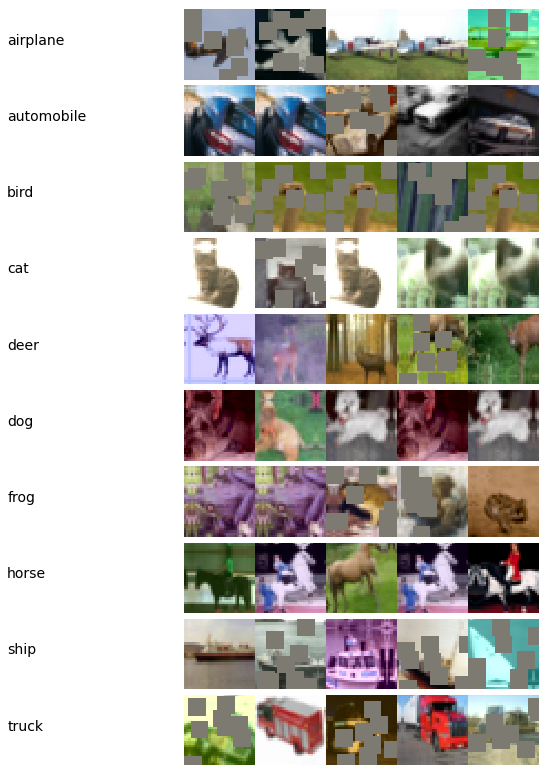

In [0]:
from __future__ import print_function
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Model Summary

In [0]:
import A11 
import torch

model = A11.Quiz11()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
model.summary((3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,456
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,456
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

# LR_Finder

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



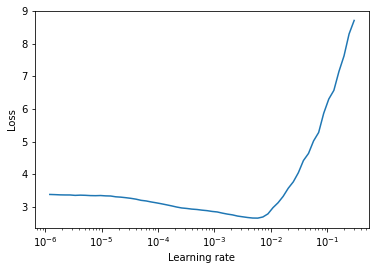

In [0]:
from lrfinder import LRFinder
import torch.optim as optim
import torch.nn as nn

L1lambda = 0
L2lambda = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9, nesterov=True, weight_decay=L2lambda)
lr_finder = LRFinder(model, optimizer, criterion, device=model.device)
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

# Train and Test the Model

In [0]:
#from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR
EPOCHS = 25
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
#scheduler = ReduceLROnPlateau(optimizer, min_lr=1e-7, patience = 1)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.03, total_steps=25, epochs=25, pct_start=0.2, anneal_strategy='cos', cycle_momentum=False, base_momentum=0.85, max_momentum=0.95, div_factor=25., final_div_factor=1e4, last_epoch=-1)
model.gotrain(optimizer, train_loader, test_loader, EPOCHS, "/content/drive/My Drive", scheduler, False, L1lambda)


Validation loss decreased (100000.000000 --> 1.192683).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0132, Accuracy: 39.87%; Test set: Average loss: 1.1927, Accuracy: 57.21%
Learning Rate = 0.001200



Epoch: 2, Train set: Average loss: 0.0120, Accuracy: 47.09%; Test set: Average loss: 1.2608, Accuracy: 60.08%
Learning Rate = 0.005418



Validation loss decreased (1.192683 --> 1.065170).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0121, Accuracy: 50.03%; Test set: Average loss: 1.0652, Accuracy: 64.71%
Learning Rate = 0.015600



Validation loss decreased (1.065170 --> 0.807955).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0102, Accuracy: 56.45%; Test set: Average loss: 0.8080, Accuracy: 73.33%
Learning Rate = 0.025782



Validation loss decreased (0.807955 --> 0.725034).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0086, Accuracy: 62.01%; Test set: Average loss: 0.7250, Accuracy: 75.69%
Learning Rate = 0.030000



Validation loss decreased (0.725034 --> 0.670577).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0076, Accuracy: 66.38%; Test set: Average loss: 0.6706, Accuracy: 77.86%
Learning Rate = 0.029815



Validation loss decreased (0.670577 --> 0.650759).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0070, Accuracy: 69.16%; Test set: Average loss: 0.6508, Accuracy: 78.57%
Learning Rate = 0.029266



Validation loss decreased (0.650759 --> 0.593424).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0065, Accuracy: 71.23%; Test set: Average loss: 0.5934, Accuracy: 80.23%
Learning Rate = 0.028365



Validation loss decreased (0.593424 --> 0.486640).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0060, Accuracy: 73.18%; Test set: Average loss: 0.4866, Accuracy: 83.61%
Learning Rate = 0.027135



Validation loss decreased (0.486640 --> 0.464910).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0057, Accuracy: 74.63%; Test set: Average loss: 0.4649, Accuracy: 84.60%
Learning Rate = 0.025607



Validation loss decreased (0.464910 --> 0.428562).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0054, Accuracy: 76.16%; Test set: Average loss: 0.4286, Accuracy: 85.64%
Learning Rate = 0.023817



Validation loss decreased (0.428562 --> 0.398444).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0051, Accuracy: 77.52%; Test set: Average loss: 0.3984, Accuracy: 86.51%
Learning Rate = 0.021810



Validation loss decreased (0.398444 --> 0.381168).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0048, Accuracy: 78.59%; Test set: Average loss: 0.3812, Accuracy: 87.08%
Learning Rate = 0.019635



Validation loss decreased (0.381168 --> 0.371563).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0046, Accuracy: 79.75%; Test set: Average loss: 0.3716, Accuracy: 87.47%
Learning Rate = 0.017347



Validation loss decreased (0.371563 --> 0.369662).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0043, Accuracy: 80.87%; Test set: Average loss: 0.3697, Accuracy: 87.87%
Learning Rate = 0.015000



Validation loss decreased (0.369662 --> 0.341447).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0042, Accuracy: 81.80%; Test set: Average loss: 0.3414, Accuracy: 89.08%
Learning Rate = 0.012654



Validation loss decreased (0.341447 --> 0.323256).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0039, Accuracy: 82.56%; Test set: Average loss: 0.3233, Accuracy: 88.99%
Learning Rate = 0.010365



Validation loss decreased (0.323256 --> 0.300259).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0037, Accuracy: 83.65%; Test set: Average loss: 0.3003, Accuracy: 90.00%
Learning Rate = 0.008190



Validation loss decreased (0.300259 --> 0.296178).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0036, Accuracy: 84.05%; Test set: Average loss: 0.2962, Accuracy: 90.23%
Learning Rate = 0.006183



Validation loss decreased (0.296178 --> 0.280167).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0034, Accuracy: 84.66%; Test set: Average loss: 0.2802, Accuracy: 90.77%
Learning Rate = 0.004394



Validation loss decreased (0.280167 --> 0.276879).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0033, Accuracy: 85.37%; Test set: Average loss: 0.2769, Accuracy: 90.71%
Learning Rate = 0.002865



Validation loss decreased (0.276879 --> 0.270094).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0032, Accuracy: 85.85%; Test set: Average loss: 0.2701, Accuracy: 90.79%
Learning Rate = 0.001635



Validation loss decreased (0.270094 --> 0.267802).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0031, Accuracy: 86.12%; Test set: Average loss: 0.2678, Accuracy: 90.94%
Learning Rate = 0.000734



Epoch: 24, Train set: Average loss: 0.0031, Accuracy: 86.32%; Test set: Average loss: 0.2681, Accuracy: 90.98%
Learning Rate = 0.000185



Epoch: 25, Train set: Average loss: 0.0031, Accuracy: 86.25%; Test set: Average loss: 0.2684, Accuracy: 90.99%
Learning Rate = 0.000000



# Plotting One cycle LR and Loss

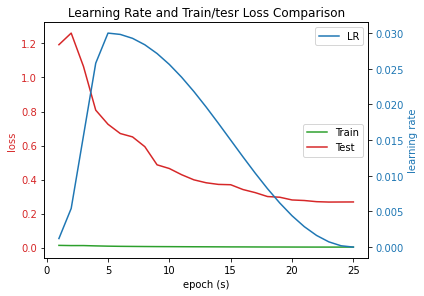

In [0]:
fig, ax1 = plt.subplots()
t = np.arange(1,26)
color = 'tab:red'
ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('loss',color=color)
testline, =  ax1.plot(t,model.stats().avg_test_loss, color=color)
ax1.tick_params(axis='y',labelcolor=color)

color = 'tab:green'
trainline, = ax1.plot(t,model.stats().avg_train_loss,color=color)
ax1.legend((trainline,testline), ('Train','Test'), loc=7)
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('learning rate',color=color)
lrline, = ax2.plot(t,model.stats().lr, color = color)
ax2.legend((lrline, ), ('LR',), loc=1)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title("Learning Rate and Train/tesr Loss Comparison")
plt.show()

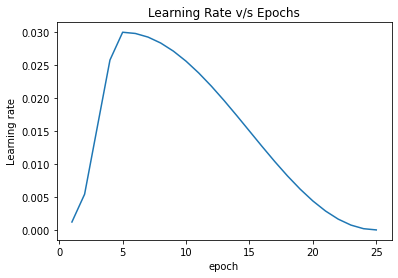

In [0]:
import matplotlib.pyplot as plt
epochs = []
for i in range(25):
  epochs.append(i+1)

plt.plot(epochs,model.stats().lr)
plt.ylabel('Learning rate')
plt.xlabel("epoch")
plt.title("Learning Rate v/s Epochs")
plt.show()

# Triangular Plot

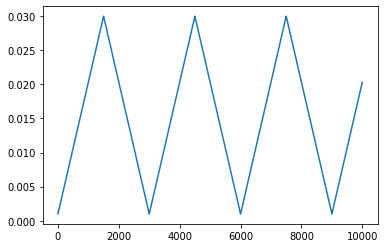

In [0]:
def get_triangular_lr(iteration, stepsize, base_lr, max_lr):
    """Given the inputs, calculates the lr that should be applicable for this iteration"""
    cycle = np.floor(1 + iteration/(2  * stepsize))
    x = np.abs(iteration/stepsize - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * np.maximum(0, (1-x))
    return lr


num_iterations = 10000
stepsize = 1500
base_lr = 0.001
max_lr = 0.03
lr_trend = list()

for iteration in range(num_iterations):
    lr = get_triangular_lr(iteration, stepsize, base_lr, max_lr)
    # Update your optimizer to use this learning rate in this iteration
    lr_trend.append(lr)

plt.plot(lr_trend)

# Plotting Train and Test Accuracy

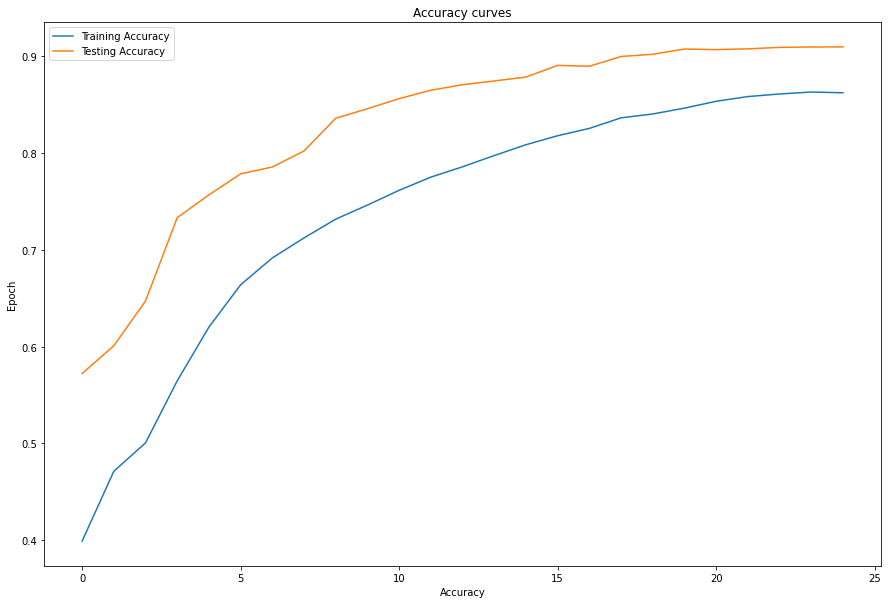

In [0]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model.stats().train_acc)
ax.plot(model.stats().test_acc)

ax.set(title="Accuracy curves", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['Training Accuracy', 'Testing Accuracy'], loc='best')
plt.savefig("TrainTestAccuracy.png")
plt.show()

# Plot Misclassified Images

In [0]:
len(model.stats().get_misclassified_images())

25

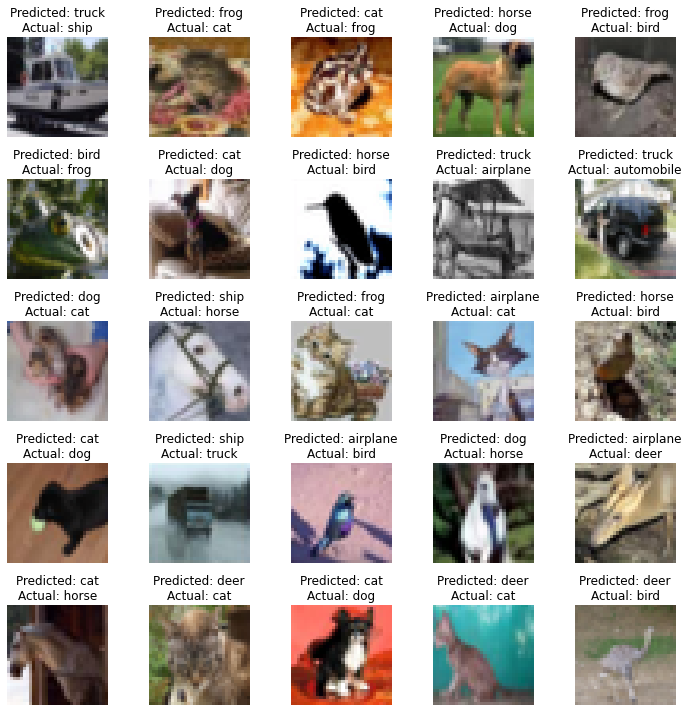

In [0]:
import plots
plots.plot_images(model.stats().get_misclassified_images(), class_names, "misclassified_imgs.png", mean=list(channel_means), std=list(channel_stdevs))


Submitted By
G Uday Kiran
V Srilakshmi